<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/9_Feature_engineer_select/9_2_Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 9: Principles of Feature Engineering and Selection

# 9.2  Histogram Features

A histogram is an extremely simple yet useful way of summarizing and representing the contents of an array of numbers as a vector, showing how many times each number appears in the array. In this Section we see how this rather simple concept is at the core of designing features for special types of input data. Specifically we discuss how this simple concept can be used to design features for each of categorical, text, image, and audio data types. Although each of these data types differs substantially in nature, we will see how the notion of a histogram-based feature makes sense in each context. While histogram features are not guaranteed to produce perfect separation, their simplicity and all around solid performance makes them quite popular in practice.

Lastly, note that the discussion in this Section is only aimed at giving the reader a high level, intuitive understanding of how common knowledge-driven feature design methods work. The interested reader is encouraged to consult specialized texts (referenced throughout this Section) on each subject for further study. 

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_9_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/9_Feature_engineer_select/chapter_9_datasets
    else:
        print('chapter_9_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_9_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/9_Feature_engineer_select/chapter_9_library
    else:
        print('chapter_9_library already cloned!')

    # clone images
    if not Path('chapter_9_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/9_Feature_engineer_select/chapter_9_images
    else:
        print('chapter_9_images already cloned!')

    # clone videos
    if not Path('chapter_9_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/9_Feature_engineer_select/chapter_9_videos
    else:
        print('chapter_9_videos already cloned!')

# image paths
image_path_1 = "chapter_9_images/blood_type_real_axis.png"
image_path_2 = "chapter_9_images/blood_type_histogram.png"
image_path_3 = "chapter_9_images/cat_dog_example.png"
image_path_4 = "chapter_9_images/team_america.png"
image_path_5 = "chapter_9_images/positive-negative-neutral.png"
image_path_6 = "chapter_9_images/document-clustering.png"
image_path_7 = "chapter_9_images/close_up.png"
image_path_8 = "chapter_9_images/edge_detection.png"
image_path_9 = "chapter_9_images/neuron.png"
image_path_10 = "chapter_9_images/HOG.png"
image_path_11 = "chapter_9_images/spectrum.png"
image_path_12 = "chapter_9_images/mfcc.png"

# standard imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy
from IPython.display import Image

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

##  Histogram features for categorical data

Every machine learning paradigm requires that the data we deal with consists strictly of *numerical values*, however raw data does not always come pre-packaged in this manner. Consider, for instance, a hypothetical medical dataset consisting of several patients' vital measurements such as blood pressure, blood glucose level, and blood type, as input. The first two features (i.e., blood pressure and blood glucose level) are naturally numerical, and hence ready for supervised or unsupervised learning. Blood type on the other hand is a *categorical* feature, taking on as value one of four categories: O, A, B, and AB. How can one translate these categories into numerical values decipherable by a machine learning algorithm?

A first, intuitive approach would be to represent each category with a distinct real number, e.g., by assigning 0 to the blood type O, 1 to A, 2 to B, and 3 to AB, as shown in the left panel of the figure below. Here, the way we assign numbers to each category is important. In this particular instance, by assigning 1 to A, 2 to B, and 3 to AB, we have tacitly made the assumption that, everything else the same, an individual with blood type AB is more 'similar' to one with blood type B than one with blood type A. This is because the number 3 is closer to number 2 than it is to number 1 on the real axis. One could argue that it is more appropriate to switch the numbers used to represent categories B and AB so that AB now sits between (and hence equidistant from) A and B, as shown in the right panel of the figure below. With this reassignment, blood type O still neighbors A but is now maximally away from B - an assumption that *may* or *may not* be true in reality.


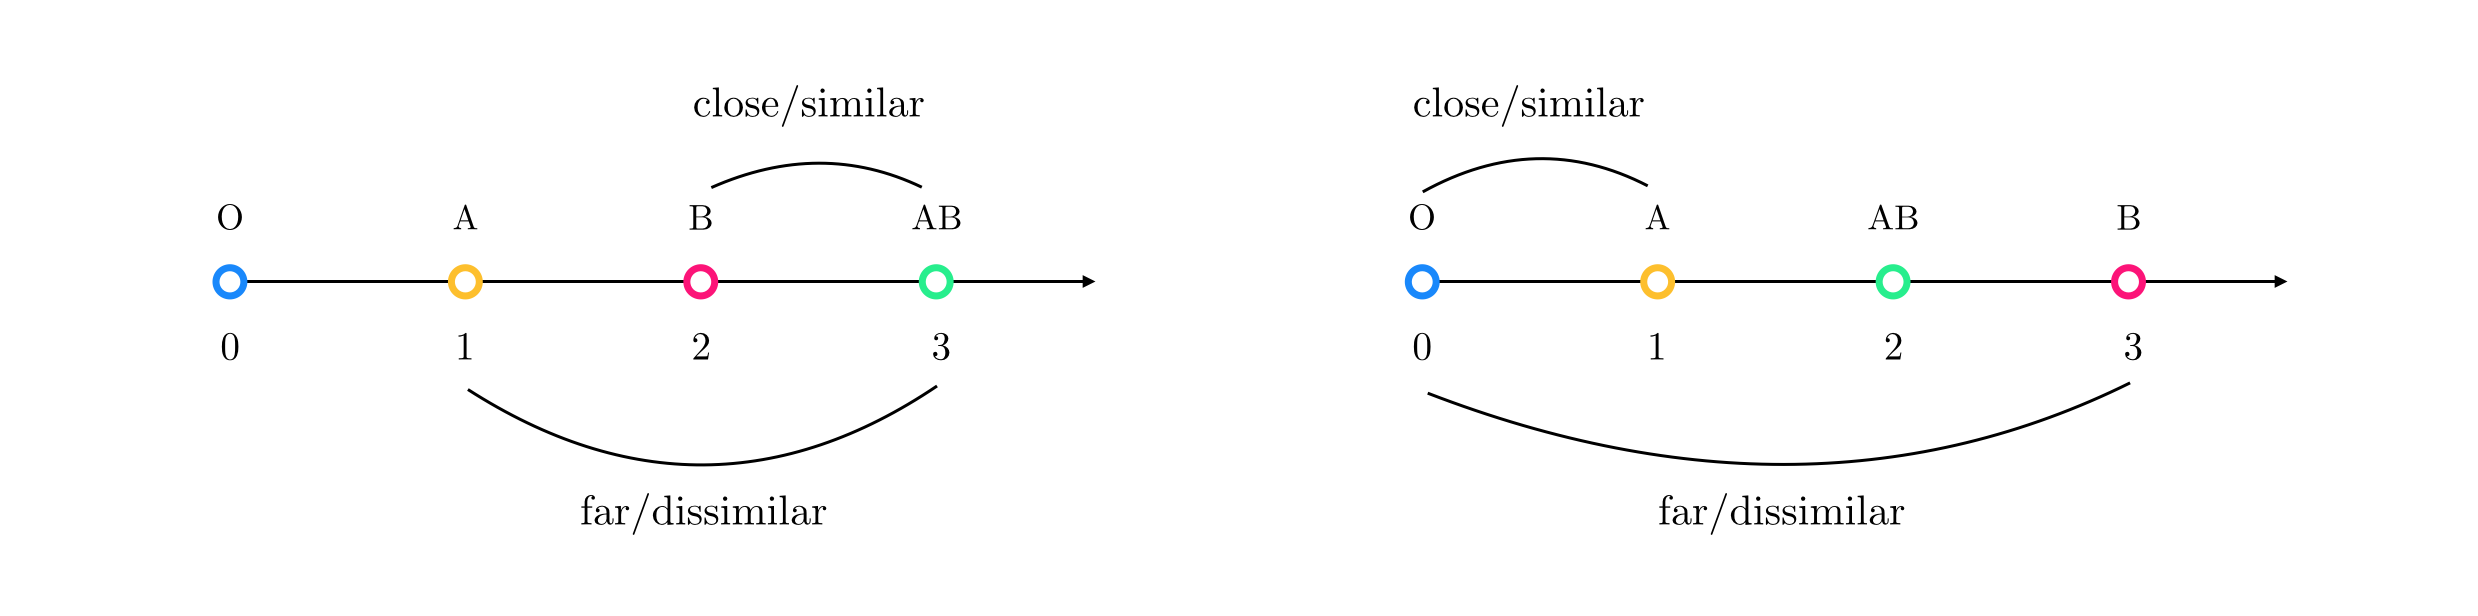

In [ ]:
Image(image_path_1)

The crux of the matter here is that there is always a natural order to any set of numbers chosen on the real axis, and by using such numbers we inevitably make assumptions about similarity or dissimilarity of the existing categories in the data. In most cases we want to avoid making such assumptions that fundamentally change the shape/geometry of the problem, especially when we lack the intuition/knowledge necessary for determining similarity between different categories.    

A better way of encoding categorical features is to use a simple histogram whose bins are all categories  present in the categorical feature of interest (here, blood type). Then, an individual with blood type O is no longer represented by a single number but by a four-binned histogram wherein the count associated with bin O is 1 while all the rest are set to zero. Individuals with other blood types are represented similarly (see figure below).

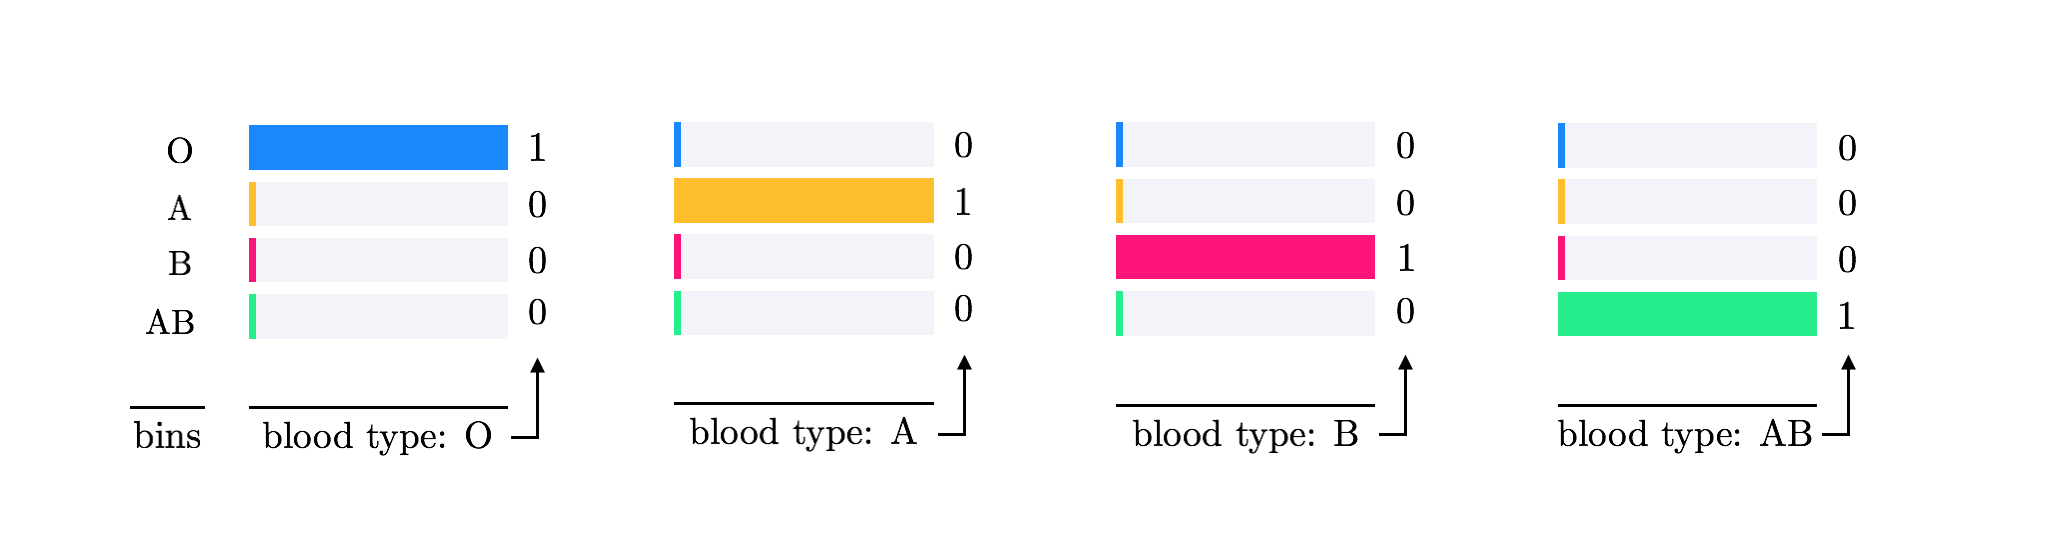

In [ ]:
Image(image_path_2)

This way, all blood type representations (each a four dimensional vector with a single one and three zeros) are equidistant from one another. This method of encoding categorical features, sometimes referred to as *one-hot encoding*, can also be thought of as replacing the original blood type feature with four new 'dummy' features that take on binary values:

* Is blood type **O**? 1 if yes; 0 if no
* Is blood type **A**? 1 if yes; 0 if no
* Is blood type **B**? 1 if yes; 0 if no
* Is blood type **AB**? 1 if yes; 0 if no

##  Histogram features for text data

Many popular uses of machine learning, including sentiment analysis, spam detection, document categorization or clustering, and more, are based on text data (e.g., online news articles, emails, social-media updates, etc.). However with text data, the initial input (i.e., the document itself) requires a significant amount of preprocessing and transformation prior to further feature design and supervised/unsupervised learning. The most basic yet widely used feature of a document for machine learning tasks is called a *Bag of Words* (BoW) histogram or feature vector. Here we introduce the BoW histogram and discuss its strengths, weaknesses, and common extensions.

A BoW feature vector of a document is a simple histogram count of the different words it contains with respect to a single corpus or collection of documents (each count of an individual word is a feature, and taken together gives a feature vector), minus those non-distinctive words that do not characterize the document (in the context of the application). To illustrate this idea let us build a BoW representation for the following corpus of two simple documents each containing a single sentence. 

\begin{equation}
\begin{array}{c}
1)\,\,\mbox{dogs are the best} \\
\,\,2)\,\,\mbox{cats are the worst}
\end{array}
\label{eq:cat-dog}
\end{equation}

To make the BoW representation of these documents we begin by parsing them, creating representative vectors (histograms) $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$ which contain the number of times each word appears in each document. For the two documents above these vectors take the form shown in Figure below.


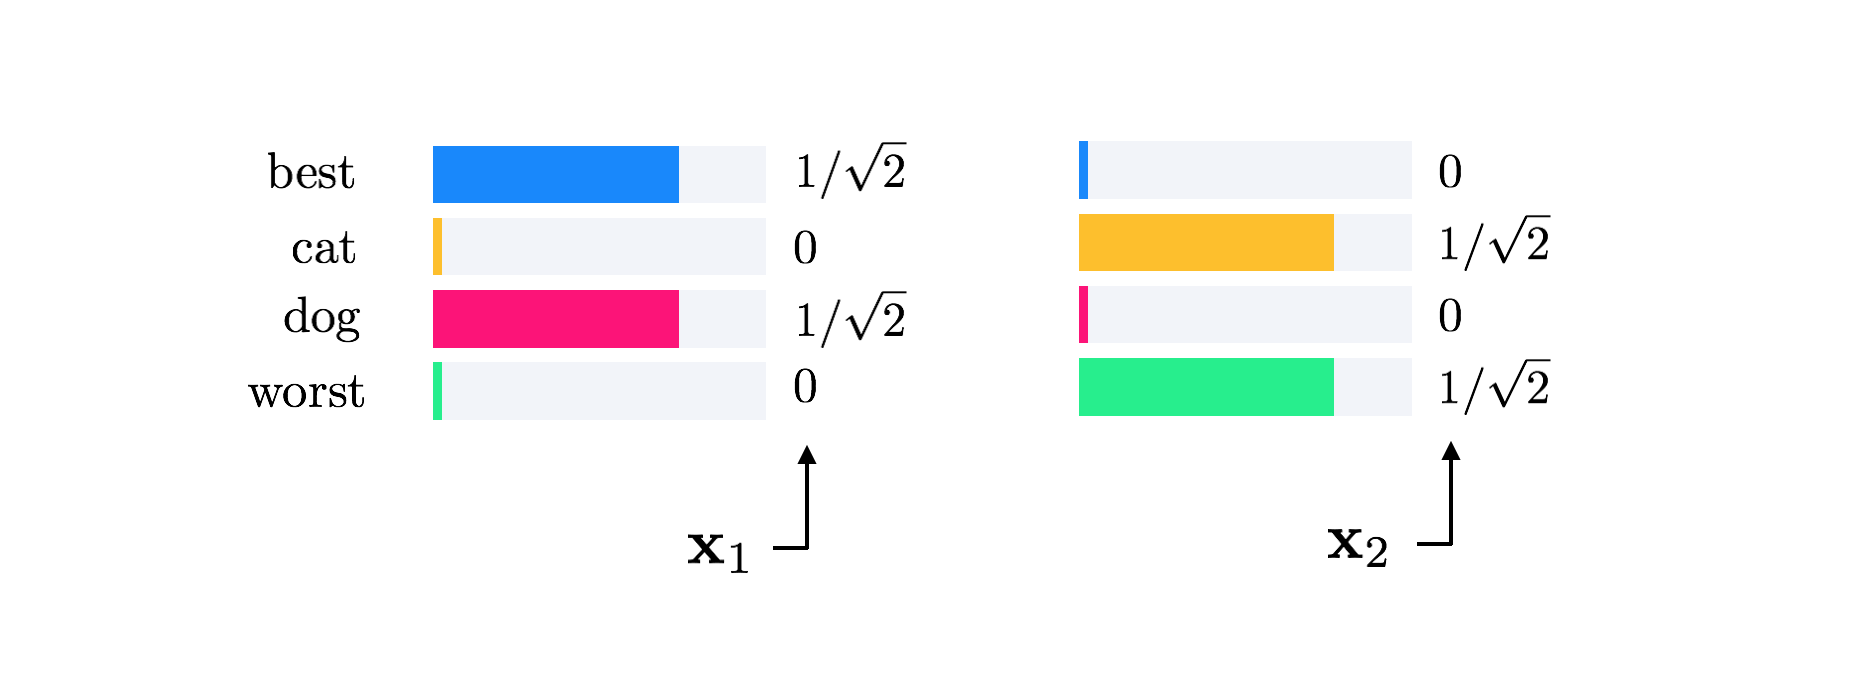

In [ ]:
Image(image_path_3)

Notice that in creating the BoW histograms uninformative words such as 'are' and 'the', typically referred to as *stop words*, are not included in the representation. Further notice that we count the singular 'dog' and 'cat' in place of their plural which appeared in the original documents. This preprocessing step is commonly called *stemming*, where related words with a common stem or root are reduced to and then represented by their common root. For instance, the words 'learn', 'learning', 'learned', and 'learner', in the final BoW feature vector are all represented by and counted as 'learn'. Additionally, each BoW vector is normalized to have unit length. 

Given that the BoW vector contains only non-negative entries and has unit length, the correlation between two BoW vectors $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$ always ranges between $0$ and $1$, i.e., $0\leq\mathbf{x}_{1}^{T}\mathbf{x}_{2}^{\,}\leq1$. When the correlation is zero (i.e., the vectors are perpendicular), as with the two vectors in Figure above, the two vectors are considered maximally different and will therefore
(hopefully) belong to different classes. In the instances shown in Figure above the fact that $\mathbf{x}_{1}^{T}\mathbf{x}_{2}=0$ makes sense: the two documents are completely different, containing entirely different words and polar opposite sentiment. On the other hand the higher the correlation between two vectors the more similar the documents are purported to be, with highly correlated documents (hopefully) belonging to the same class. For example, the BoW vector of the document ``I love dogs`` would have positive correlation with $\mathbf{x}_{1}$ in Figure above. 

However because the BoW vector is such a simple representation of a document, completely ignoring word order, punctuation, etc., it can only provide a gross summary of a document's contents and is thus not always distinguishing. For example, the two documents ``dogs are better than cats`` and ``cats are better than dogs`` would be considered the same document using BoW representation, even though they imply completely opposite relations. Nonetheless the gross summary provided by BoW can be distinctive enough for many applications. Additionally, while more complex representations of documents (capturing word order, parts of speech, etc.,) may be employed they can often be unwieldly (see e.g., \cite{manning1999foundations}).

#### <span style="color:#a50e3e;">Example 1. </span>  Sentiment analysis

Determining the aggregated feelings of a large base of customers, using text-based content like product reviews, tweets, and comments, is commonly referred to as *sentiment analysis* (as first discussed in Chapter 1). Classification models are often used to perform sentiment analysis, learning to identify consumer data of either positive or negative feelings.

For example, the top panel of Figure below shows BoW vector representations for two brief reviews of a controversial comedy movie, one with a positive opinion and the other with a negative one. The BoW vectors are rotated sideways in this Figure so that the horizontal axis contains the common words between the two sentences (after stop word removal
and stemming). The polar opposite sentiment of these two reviews is perfectly represented in their BoW representations, which as one can see are orthogonal (i.e., they have zero correlation). In general, two documents with opposite sentiments are not - and need not always be - perpendicular for sentiment analysis to work effectively, even though we ideally expect them to have small correlations, as shown in the bottom panel of Figure below.

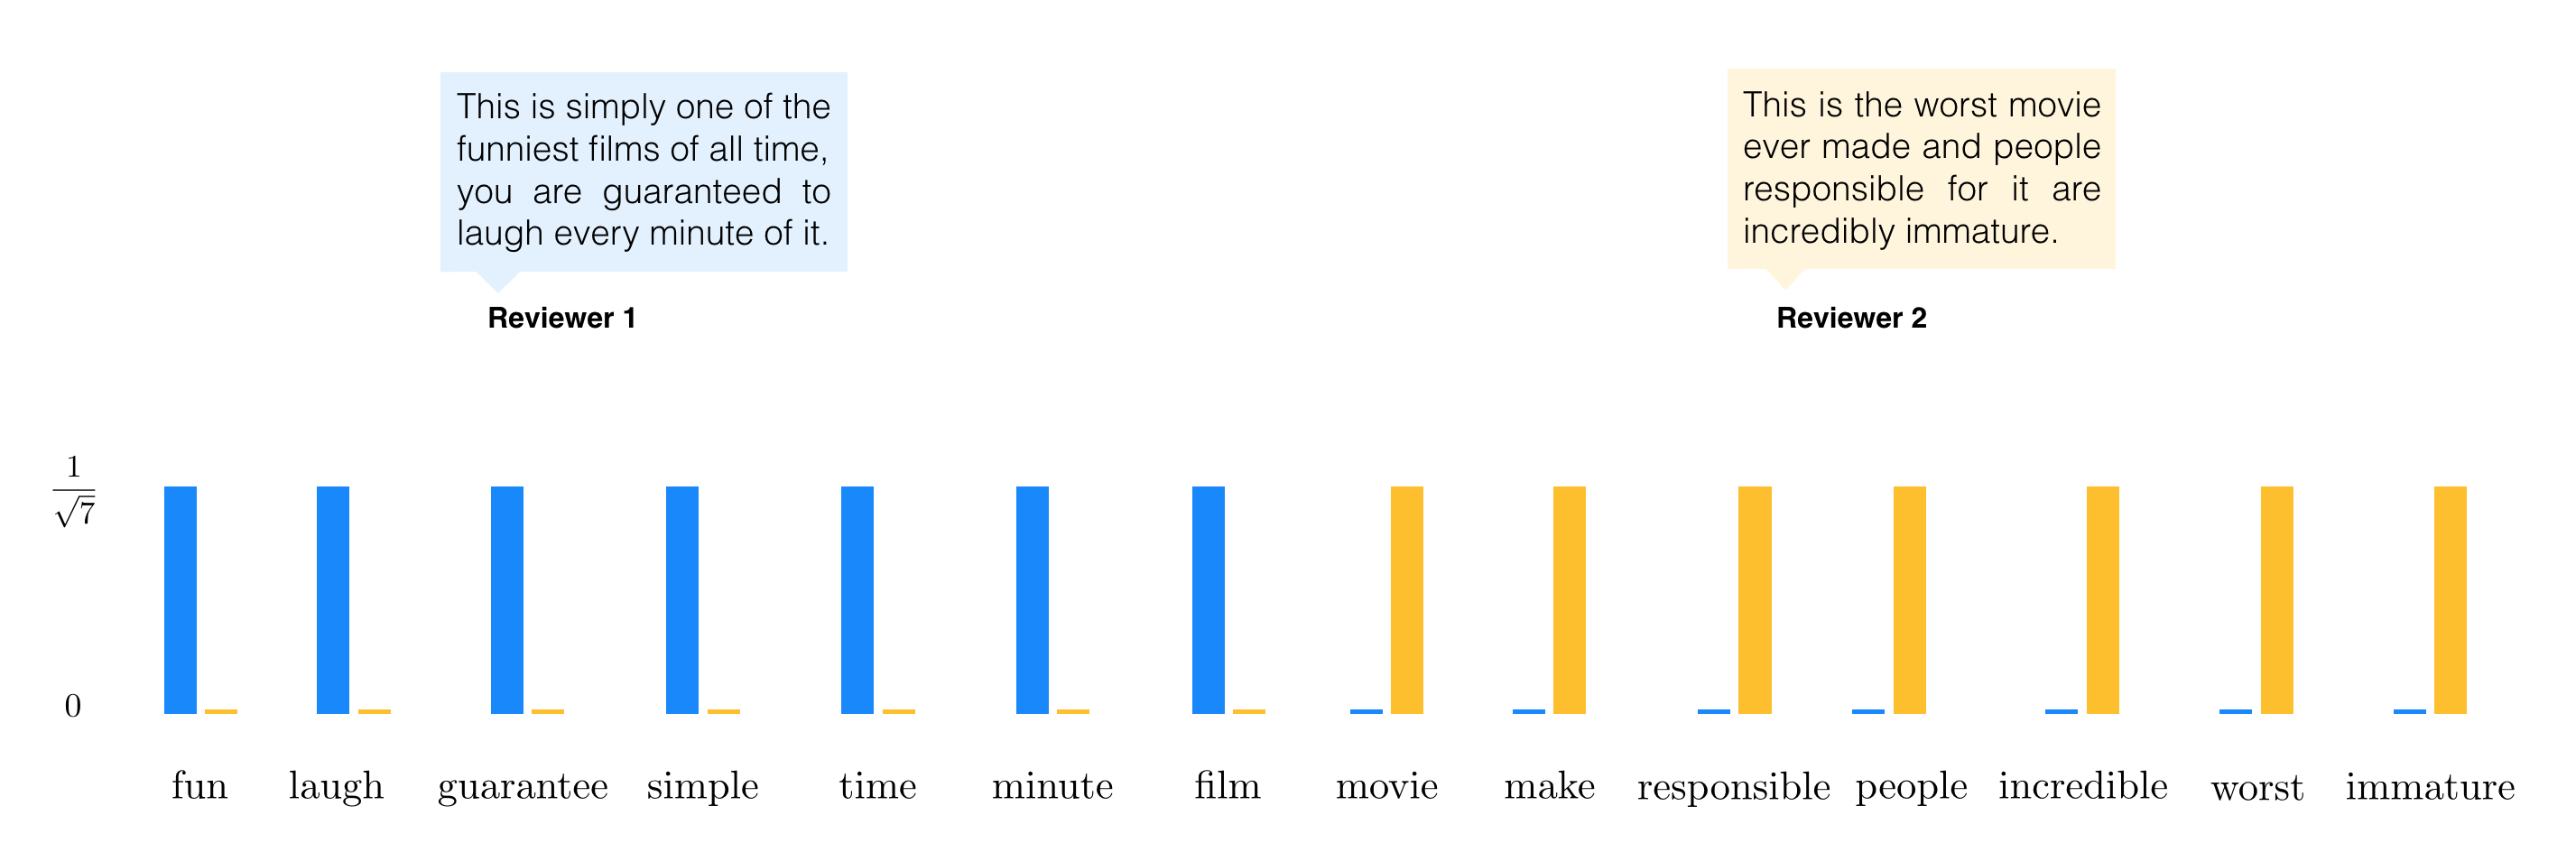

In [ ]:
Image(image_path_4)

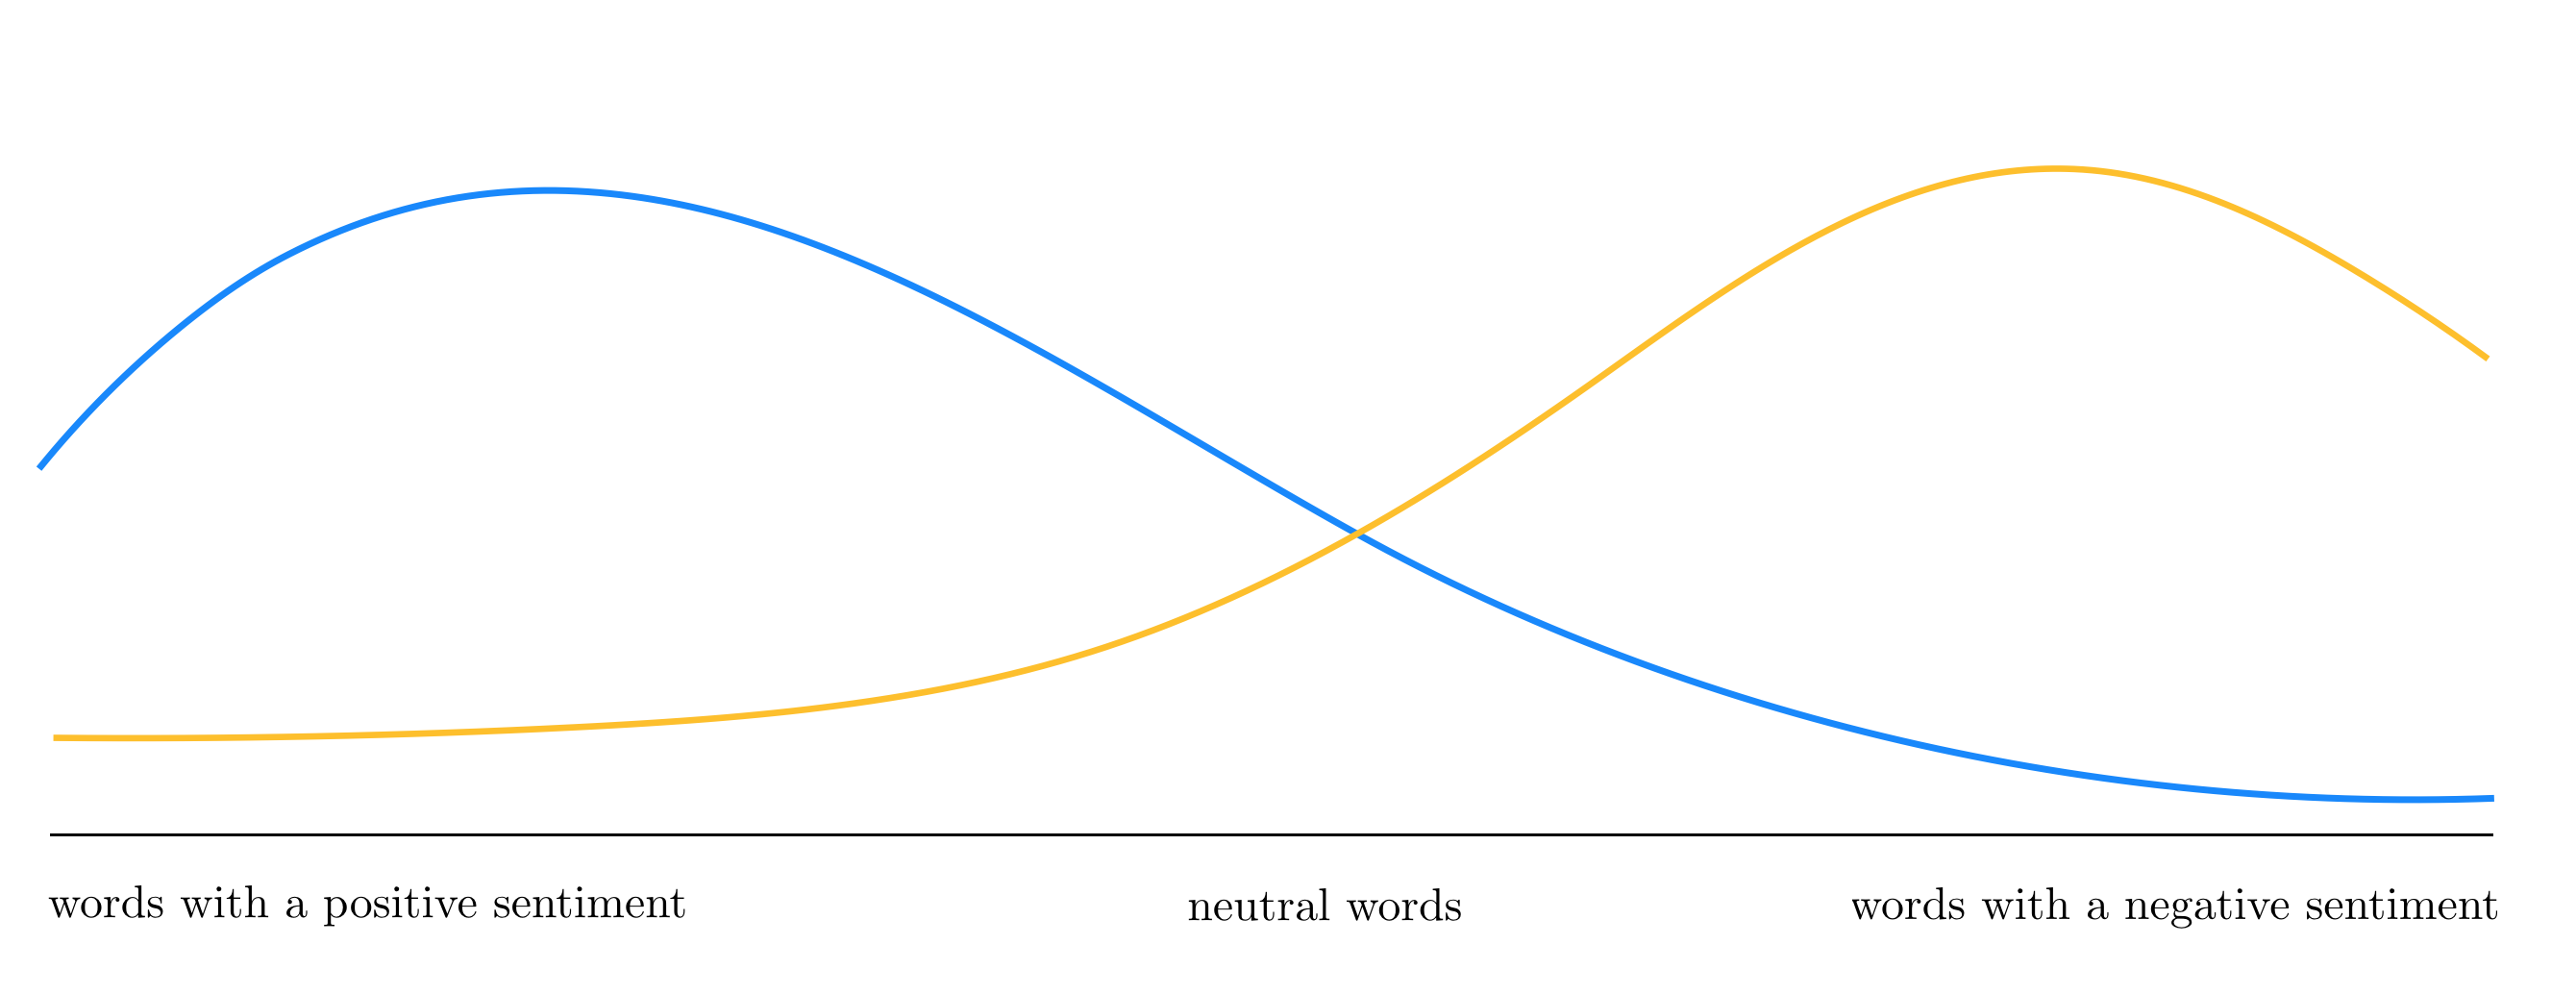

In [ ]:
Image(image_path_5)

<figure>
  <figcaption>   
<strong>Figure:</strong> (top panel) BoW representation of two movie review excerpts, with words (after the removal of stop words and stemming) shared between the two reviews listed along the horizontal axis. The vastly different opinion of each review is reflected very well by the BoW histograms, which have zero correlation. (bottom panel) In general, the BoW histogram of a typical document with positive sentiment is ideally expected to have small correlation with that of a typical document with negative sentiment.  </figcaption> 
</figure>

#### <span style="color:#a50e3e;">Example 2. </span>  Spam detection

Spam detection is a standard text-based two class classification problem.  Implemented in most email systems, spam detection automatically identifies unwanted messages (e.g., advertisements), referred to as spam, from the emails users want to see. Once trained, a spam detector can remove unwanted messages without user input, greatly improving a user's email experience. In many spam detectors the BoW feature vectors are formed with respect to a specific list of spam words (or phrases) including 'free', 'guarantee', 'bargain', 'act now', 'all natural' , etc., that are frequently seen in spam emails. Additionally features like the frequency of certain characters like '!' and '{*}' are appended to
the BoW feature, as are other spam-targeted features like the total number of capital letters in the email and the length of longest uninterrupted sequence of capital letters, as these features can further distinguish the two classes. See this Chapter exercises. 

#### <span style="color:#a50e3e;">Example 3. </span>  Document clustering

The web, email, and social media regularly produce massive amounts of uncategorized documents. Clustering such documents groups together those of similar type or topic, as illustrated pictorially in Figure below, organizing the materials for better presentation to a human user. This is helpful in understanding, for example, web search results returned from a query. By clustering search results they can place into topics for easier sorting and perusing. In addition, cluster based information retrieval can also provide computationally faster search results [manning2008introduction].

In Figure below we provide a graphic that illustrates the prototypical document clustering result. In this instance we dissect a collection of documents into two clusters by learning a representative document for each cluster. The representative documents contain common words from the their respective cluster, condensing the main topic or theme of the surrounding documents. In this toy example clustering the documents reveals that the collection consisted of documents about "sports" or "politics". 

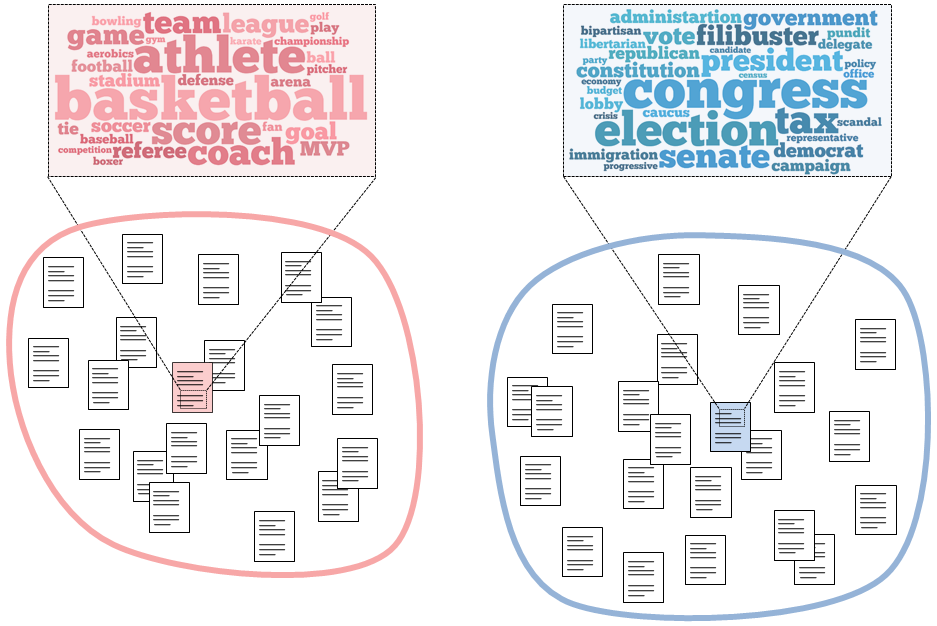

In [ ]:
Image(image_path_6)

<figure>
    
  <figcaption>   
<strong>Figure:</strong> A pictorial representation of document clustering, where a collection of documents has been clustered into two groups. Those documents within the red boundary constitute the first cluster, while those within the blue boundary are the second cluster. The red and blue documents at the center of each cluster are not part of the original collection, but are learned representatives that describe each cluster's topic or theme (in this example red is sports, and the blue is politics).  </figcaption> 
</figure>

##  Histogram features for image data 

To perform supervised/unsupervised learning tasks on image data, like object detection (see the Example below) or image compression (dimension reduction), the raw input data are pixel values of an image itself. The pixel values of an $8$-bit grayscale image are each just a single integer in the range of $0$ (black) to $255$ (white), as illustrated in Figure below.  In other words, a grayscale image is just a matrix of integers ranging from $0$ to $255$. A color image is then just a set of three such grayscale matrices: one for each of the red, blue, and green channels.

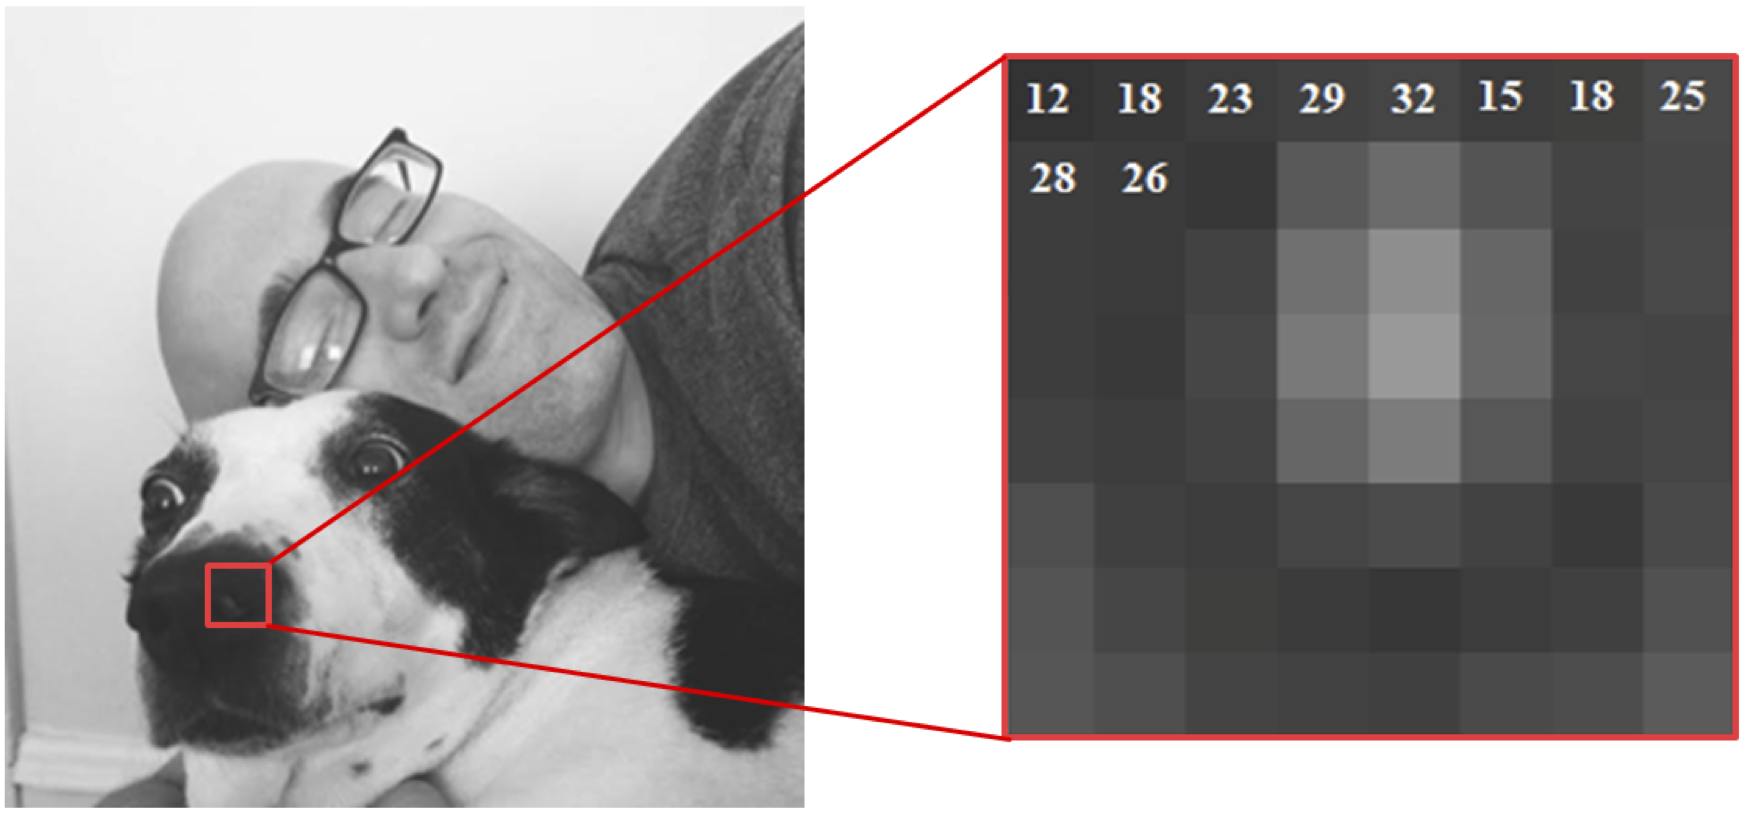

In [ ]:
Image(image_path_7)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> An $8$-bit grayscale image consists of pixels, each taking a value between $0$ (black) and $255$ (white). To visualize individual pixels, a small $8\times8$ block from the original image is blown up on the right.
</em>  </figcaption> 
</figure>

Although it is possible to use raw pixel values directly as features, this naive approach typically produces low quality results in virtually all machine learning tasks involving natural images[\*](#footnotes). Alternatively, we typically make use of an image's edge content in place of its raw pixel values, as illustrated in Figure below. 

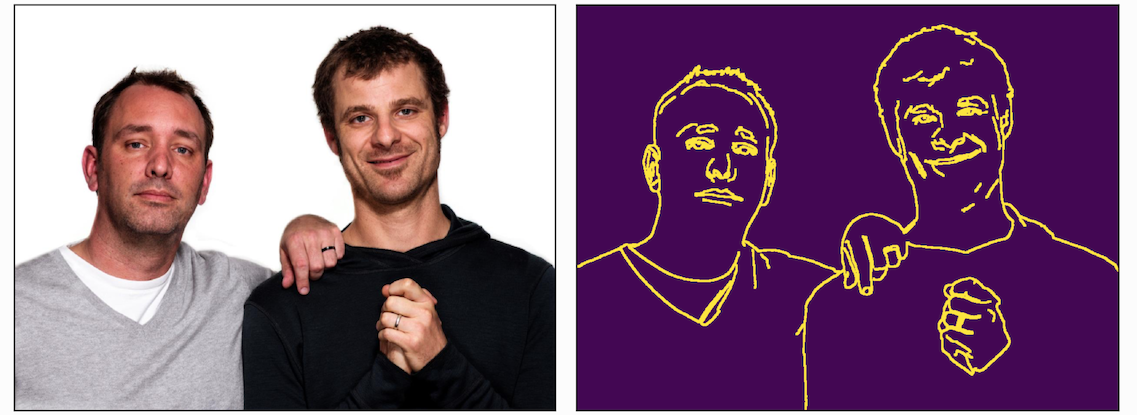

In [ ]:
Image(image_path_8)

<figure>
<figcaption> <strong>Figure 2:</strong> <em> (left panel) A natural image (in this instance of the two creators/writers of the television show 'South Park' (this image is reproduced with permission of Jason Marck). (right panel) The edge-detected version of this image, where the bright yellow pixels indicate large edge content, still describes the scene very well (in the sense that we can still tell there are two people in the image) using only a fraction of the information contained in the original image. Note that edges have been colored yellow for visualization purposes only.</em>
</figcaption>
</figure>

Notice how the edge-detected image in the right panel of Figure above is an efficient representation of the original image in the left panel in the sense that we can still tell what the image contains while throwing away a lot of information from the majority of the pixels that do not belong to any edges.

This is true in general: the distinguishing information in a natural image is largely contained in the relatively small number of edges in an image [[1,2]](#bib_cell). Interestingly, this fact is also confirmed by visual studies performed largely on frogs, cats, and primates, where a subject is shown visual stimuli while electrical impulses are recorded in a small area in the subject's brain where visual information is processed. These studies have determined that individual neurons involved in early stages of visual processing roughly operate by identifying edges [[3,4]](#bib_cell). Each neuron therefore acts as a small "edge detector," locating edges in an image of a specific orientation and thickness, as shown in Figure below. It is thought that by combining and processing these edge detected images, humans and other mammals "see."

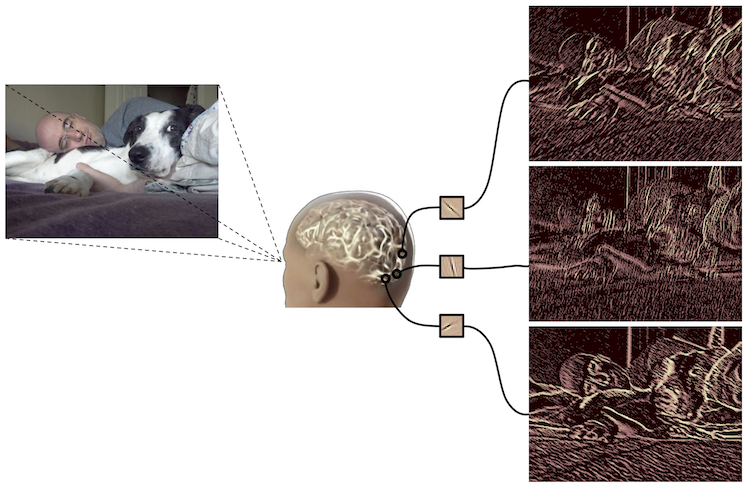

In [ ]:
Image(image_path_9)

<figure>
<figcaption> <strong>Figure 3:</strong> <em> Visual information is processed in an area of the brain where each neuron detects in the observed scene edges of a specific orientation and width. It is thought that what we (and other mammals) "see" is a processed interpolation of these edge detected images. </em>
</figcaption>
</figure>

Using an image's edge content we can make a histogram consisting of the amount of each edge orientation found in the image. This is completely analogous to the BoW feature representation described for text data previously, with the counting of edge orientations
being the analog of counting 'words' in the case of text data.

Generalizations of this simple edge histogram concept are widely used as feature transformations for visual object detection.  As detailed in Example \ref{Example-object-detection}, the task of object detection is a popular classification problem where objects of interest (e.g., faces) are located in an example image. For relatively large images, preserving local information at smaller scales becomes important. Thus a natural way to extend
the edge histogram feature is to compute it not over the entire image, but by breaking the image into relatively small patches and computing an edge histogram of each patch, then concatenating the results. In Figure \ref{fig:edge-histogram-figure} we show a diagram of a common variations of this technique often used in practice where we normalize neighboring histograms jointly in larger blocks (for further details see e.g., \cite{prince2012computer,dalal2005histograms}). Interestingly this sort of feature transformation can in fact be written out algebraically as a set of quadratic transformations of the input image \cite{bristow2014linear}. 

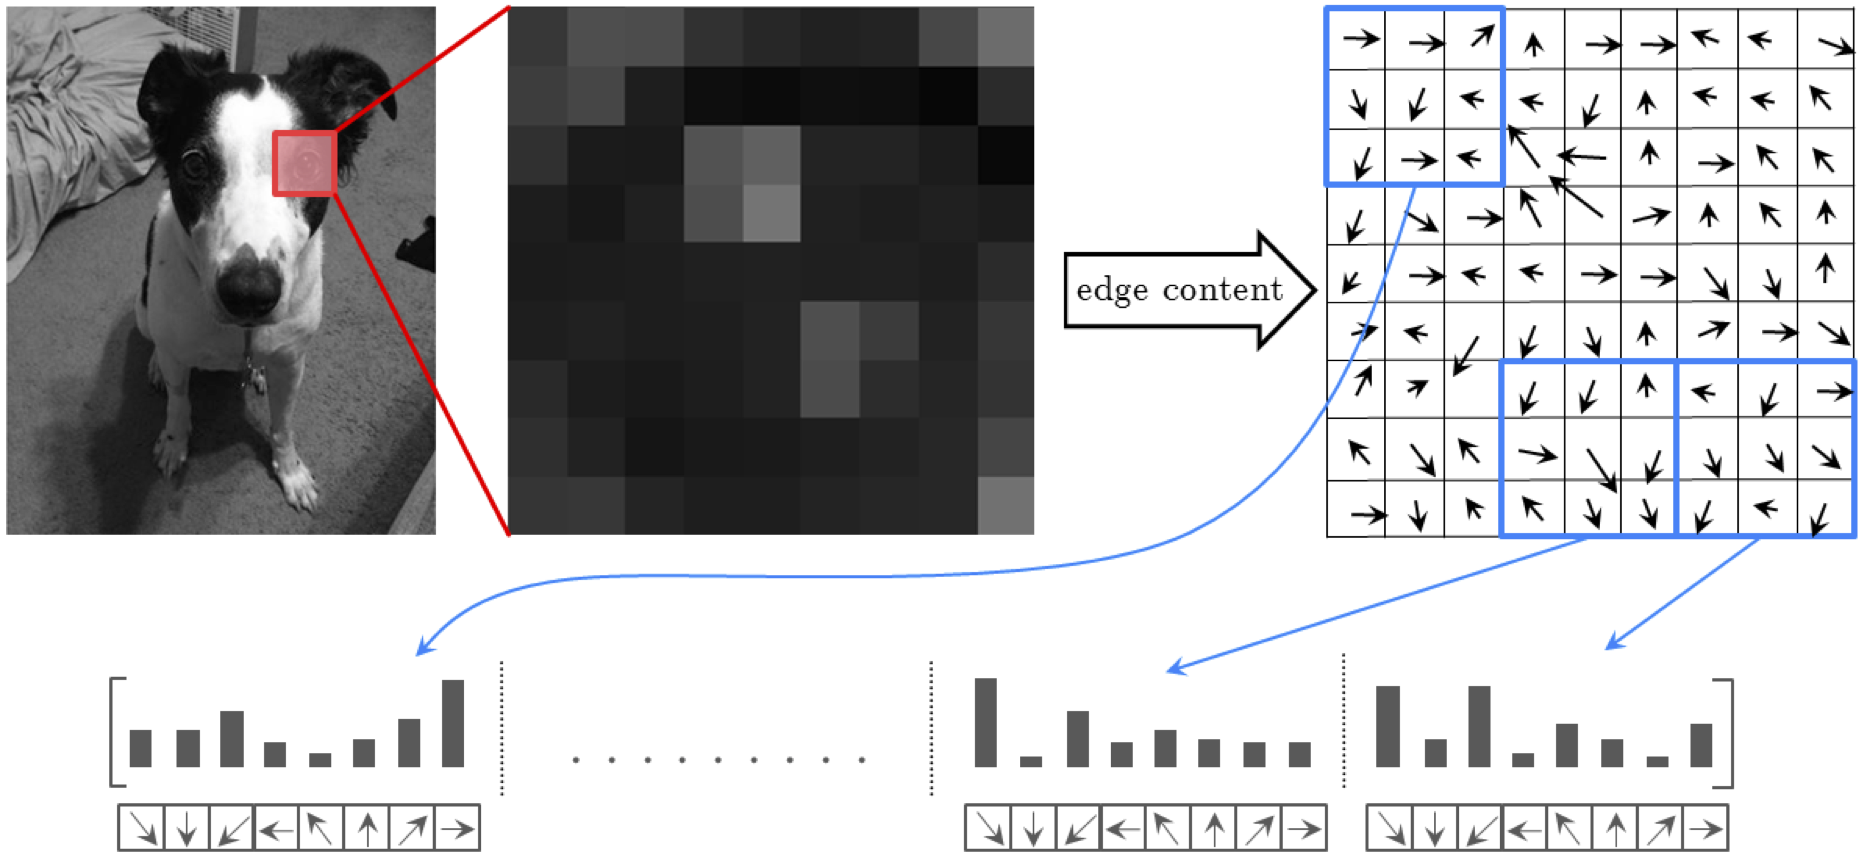

In [ ]:
Image(image_path_10)

<figure>
  <figcaption>   
<strong>Figure 4:</strong> 
<em> 
A pictorial representation
of the sort of generalized edge histogram feature transformation commonly
used for object detection. An input image is broken down into small
(here $9\times9$) blocks, and an edge histogram is computed on each
of the smaller non-overlapping (here $3\times3$) patches that make
up the block. The resulting histograms are then concatenated and normalized
jointly, producing a feature vector for the entire block. Concatenating
such block features by scanning the block window over the entire image
gives the final feature vector. 
</em>  
</figcaption> 
</figure>

## Histogram features for audio data 

Like images raw audio signals are not discriminative enough to be used for audio-based classification tasks (e.g., speech recognition) and once again properly designed histogram-based features are used. In the case of an audio signal it is the histogram of its frequencies, otherwise known as its spectrum, that provides a robust summary of its contents. As illustrated pictorially in Figure [fig:speech-histogram], the spectrum of an audio signal counts up (in histogram fashion) the strength of each level of its frequency or oscillation. This is done by decomposing the speech signal over a basis of sine waves of ever increasing frequency, with the weights on each sinusoid representing the amount of that frequency in the original signal. Each oscillation level is analogous to an edge direction in the case of an image, or an individual word in the case of a BoW text feature.

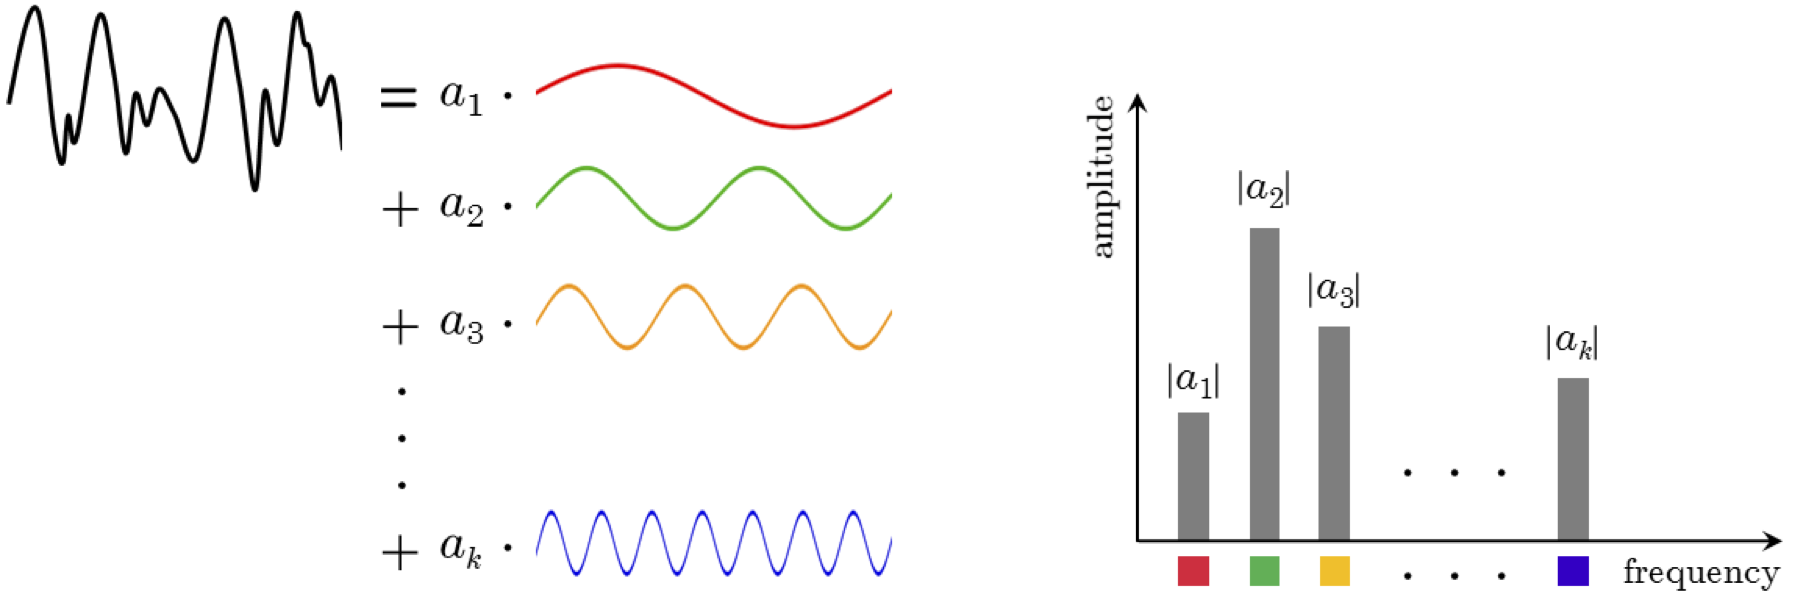

In [ ]:
Image(image_path_11)

<figure>
  <figcaption>   
<strong>Figure 7:</strong> 
<em> 
A pictorial representation of an audio signal and its representation as a frequency histogram or spectrum. (left panel) A figurative audio signal can be decomposed as a linear combination of simple sinusoids with varying frequencies (or oscillations). (right panel) The frequency histogram then contains the strength of each sinusoid in the representation of the audio signal. </em>  
</figcaption> 
</figure>

In Example [example-features-for-object-detection] we discussed how edge histograms computed on overlapping blocks of an image provide a useful feature transformation for object detection since they preserve characteristic local information. Likewise computing frequency histograms over overlapping windows of an audio signal (forming a 'spectrogram' as illustrated pictorially In Figure [fig:spectrogram]) produces a feature vector that preserves important local information as well, and is a common feature transformation used for speech recognition. Further processing of the windowed histograms, in order to e.g., emphasize the frequencies of sound best recognized by the human ear, are also commonly performed in practical implementations of this sort of feature transformation [#huang2001spoken, #rabiner1993fundamentals]. 

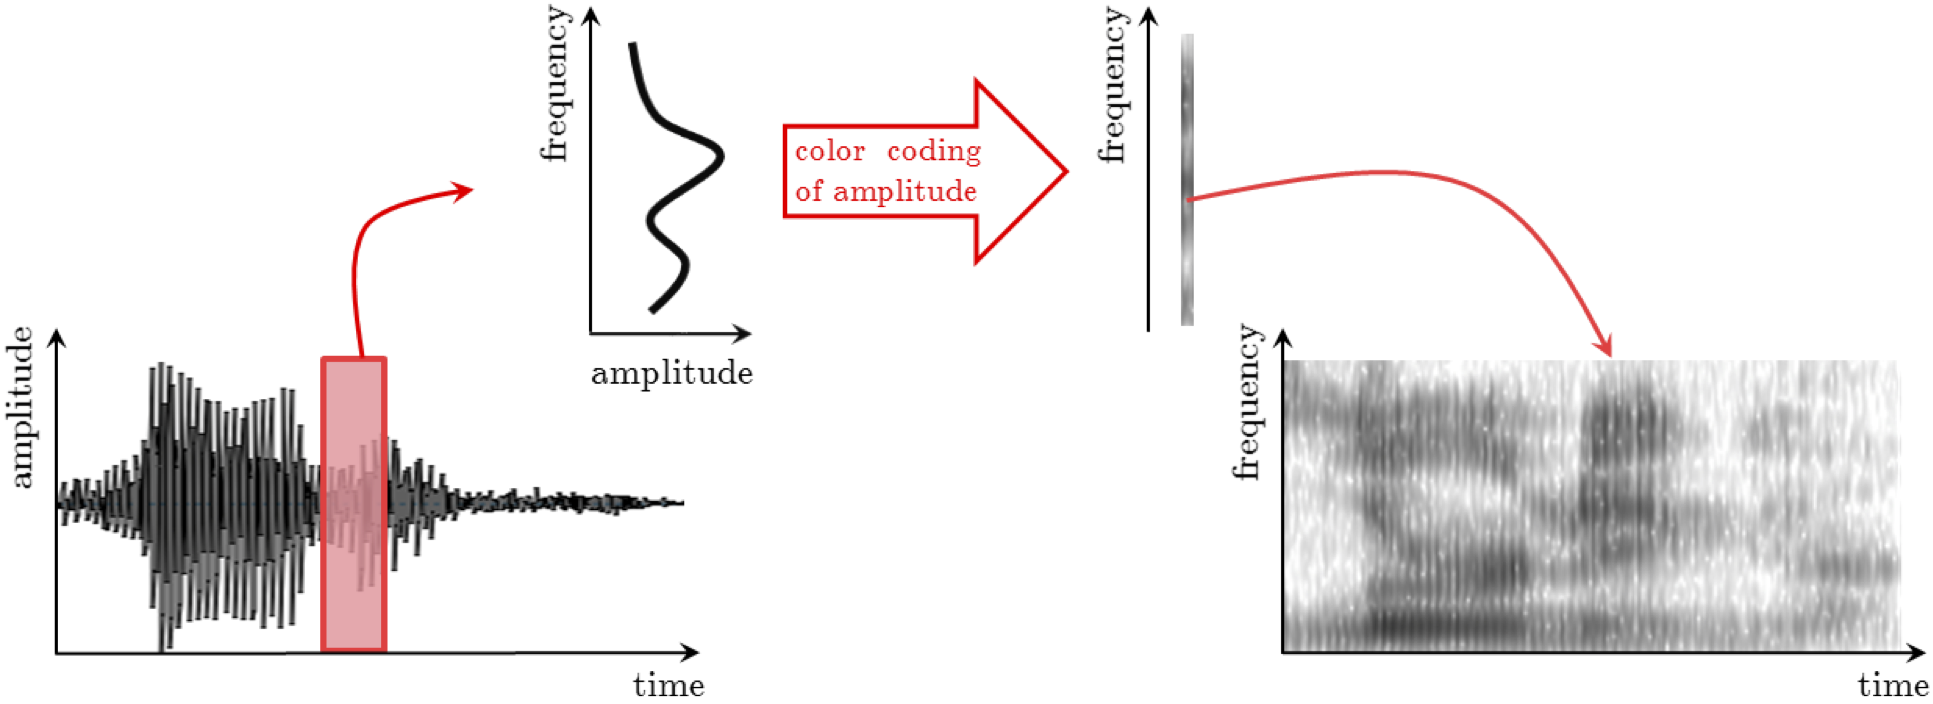

In [ ]:
Image(image_path_12)

<figure>
  <figcaption>   
<strong>Figure 5:</strong> 
<em> 
A pictorial representation of histogram-based features for audio data. The original speech signal (shown on the left) is broken up into small (overlapping) windows whose frequency histograms are computed and stacked vertically to produce a 'spectrogram' (shown on the right). Classification tasks like speech recognition are then performed using this feature representation, or a further refinement of it (see text for further details).
</em>  
</figcaption> 
</figure>

<a id='footnotes'></a>

## Footnotes

\* A natural image is an image a human being would normally be exposed to like a forest or outdoor scene, cityscapes, other people, animals, the insides of buildings, etc.